The following code aims to **predict image labels given training images with the same label categories**. The images were first processed through the inception deep learning model, then trained on a fully connected neural network (with dropout and early stopping). The final output shows the of the test images' *predicted labels*.

*Note*. Some code is commented out to save memory.

In [1]:
# --- pre-process X ---

In [2]:
import gzip
import numpy as np

In [3]:
# test_images = np.load(gzip.open('test_images.npy.gz', 'rb'))
# train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))

In [4]:
import tensorflow as tf

In [5]:
# include_top=False will discard avg_pool before prediction layer
# inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
# inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) 
# manually discard prediction layer

In [6]:
import os

In [7]:
cache_dir = 'cache/test'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [8]:
def pre_process(X, start, batch):
    """
    this function iteratively pre-processes images given start index and batch size
    """
    resize = tf.image.resize(X[start: start+batch], [299,299])
    predict = np.zeros((batch,2048))
    for i in range(0, batch):
        predict[i] = inception.predict(np.expand_dims(resize[i], axis=0))
    with open('cache/test/%s.npy'%start, 'wb') as f:
        np.save(f, predict)

In [9]:
# for j in range(0, 10, 5):
#     for k in range(j, j+5):
#         pre_process(test_images, 1000*k, 1000)

In [10]:
cache_dir = 'cache/train'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [11]:
def pre_process(X, start, batch):
    resize = tf.image.resize(X[start: start+batch], [299,299])
    predict = np.zeros((batch,2048))
    for i in range(0, batch):
        predict[i] = inception.predict(np.expand_dims(resize[i], axis=0))
    with open('cache/test/%s.npy'%start, 'wb') as f:
        np.save(f, predict)

In [12]:
# for j in range(0, 50, 5):
#     for k in range(j, j+5):
#         pre_process(train_images, 1000*k, 1000)

In [13]:
from glob import glob

In [14]:
test_dd = np.vstack([np.load(file) for file in sorted(glob('cache/test/*.npy'))])
print(test_dd.shape)

(10000, 2048)


In [15]:
train_dd = np.vstack([np.load(file) for file in sorted(glob('cache/train/*.npy'))])
print(train_dd.shape)

(50000, 2048)


In [16]:
# --- pre-process y ---

In [17]:
from tensorflow.keras.utils import to_categorical as one_hot

In [18]:
y_hot = one_hot(train_labels)

In [19]:
# --- train neural network ---

In [20]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_dd, y_hot, test_size=0.3, random_state=20240229)

In [21]:
from tensorflow import keras

In [22]:
hidden_size = 256

In [23]:
# dropout
do_rate = 0.5

In [24]:
model_fc = keras.models.Sequential()

In [25]:
model_fc.add(keras.layers.Dropout(do_rate))
model_fc.add(
    keras.layers.Dense(
        hidden_size,
        activation='relu',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=2048**-0.5)
    )
)

In [26]:
model_fc.add(keras.layers.Dropout(do_rate))
model_fc.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)

In [27]:
model_fc.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.SGD(learning_rate=0.01),
                 metrics=['accuracy'])

In [28]:
# earlystopping
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              verbose=1, min_delta=.01)

In [29]:
history = model_fc.fit(x_train, y_train,
                       epochs=100,
                       batch_size=30,
                       validation_data=(x_valid,y_valid),
                       callbacks=[earlystopping])

Epoch 1/100
1167/1167 [==============================] - 6s 5ms/step - loss: 1.1508 - accuracy: 0.6103 - val_loss: 0.6392 - val_accuracy: 0.7881
Epoch 2/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.7885 - accuracy: 0.7320 - val_loss: 0.5814 - val_accuracy: 0.8010
Epoch 3/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.7260 - accuracy: 0.7522 - val_loss: 0.5601 - val_accuracy: 0.8064
Epoch 4/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.6932 - accuracy: 0.7615 - val_loss: 0.5407 - val_accuracy: 0.8145
Epoch 5/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.6665 - accuracy: 0.7719 - val_loss: 0.5326 - val_accuracy: 0.8156
Epoch 6/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.6486 - accuracy: 0.7766 - val_loss: 0.5187 - val_accuracy: 0.8223
Epoch 7/100
1167/1167 [==============================] - 5s 4ms/step - loss: 0.6344 - accuracy: 0.7808 - val_loss: 0.5071 - val_ac

In [30]:
# --- model summary ---

In [31]:
model_fc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 527114 (2.01 MB)
Trainable params: 527114 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
import matplotlib.pyplot as plt

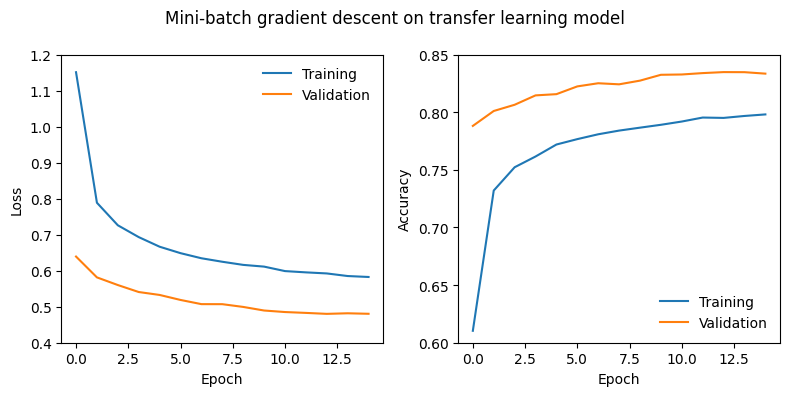

In [33]:
plt.style.use('default')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.plot(history.history['loss'], label="Training")
ax1.plot(history.history['val_loss'], label="Validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0.4, 1.2)
ax1.legend(frameon=False)

ax2.plot(history.history['accuracy'], label="Training")
ax2.plot(history.history['val_accuracy'], label="Validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.6, 0.85)
ax2.legend(loc='lower right', frameon=False)

fig.suptitle('Mini-batch gradient descent on transfer learning model')
plt.tight_layout()
plt.show()
# plt.savefig('tf.png')

In [34]:
# --- model prediction ---

In [35]:
predictions = model_fc.predict(test_dd)
pred_fc = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 2ms/step


In [36]:
print(pred_fc)
# train_labels only provided numbers

[7 9 3 ... 9 4 5]
